The training data is pulled from raw logs. It has three columns that record user activity over time:
user_id: A hash that uniquely identifies the user.
activity_date: The date of the activity
activity_type: The type of activity

Predict which users will purchase given the user's activities. 

Using the training data, build a model that predicts which user_id's will make a purchase in the future. Use the model to score the test data from most likely to least likely to purchase.

Please submit the following:

(1) Descibe which activity types you believe are most useful in predicting which user will purchase in the future.

(2) Provide a file containing the 1000 user_id's most likely to convert.

(3) [optional] Any work used to generate the list and/or notes you'd like to include.

# SUMMARY

Before any modeling was done, I aggregated all the times a person completed an action such as email click, website visit, etc. Instead of many IDs, each row represented a many times a person completed an action.

For the model, I chose the Gradient Boosted Classifier( 0.915 accuracy)  to identify who would make a purchase and Gradient Boosted Regression to estimate how many a person would purchase.  I chose this for its ensemble method, ability to improve weak learners, and being able to handle imbalanced classes.  Based on feature importance, Logs, which I aggregated as how many times a person has logged into the website is the most important feature in determining a purchase.  That is Following by Email open and afterwards the feature importance significantly drops.

Customer Support was not used as a feature of prediction since it did not map to the test set.  Although I do believe could be an important feature since everyone who purchased before at one time used Customer Support.


In [4]:
import csv
import pandas as pd
import numpy as np
from collections import Counter
from datetime import datetime
from __future__ import division
from six.moves import cPickle as pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier , GradientBoostingRegressor , RandomForestClassifier , AdaBoostClassifier
from sklearn.cross_validation import train_test_split , KFold
from sklearn.metrics import f1_score, recall_score,precision_score , confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# converting tsv data to csv
'''

with open('training.tsv','rb') as fin:
    cr = csv.reader(fin, delimiter='\t')
    filecontents = [line for line in cr]
with open('training.csv','wb') as fou:
    cw = csv.writer(fou, quotechar='', quoting=csv.QUOTE_NONE)
    cw.writerows(filecontents)
'''
# went inside the csv file and gave the columns names

"\n\nwith open('training.tsv','rb') as fin:\n    cr = csv.reader(fin, delimiter='\t')\n    filecontents = [line for line in cr]\nwith open('training.csv','wb') as fou:\n    cw = csv.writer(fou, quotechar='', quoting=csv.QUOTE_NONE)\n    cw.writerows(filecontents)\n"

In [6]:
# loading training data

train = pd.read_csv('training.csv')
train.head(20)

,ID,Date,Action
0,00002acbe042d69,7/11/13,FormSubmit
1,00002acbe042d69,7/15/13,EmailOpen
2,00002acbe042d69,7/17/13,EmailOpen
3,00002acbe042d69,7/18/13,EmailOpen
4,00002acbe042d69,7/25/13,EmailOpen
5,00002acbe042d69,7/26/13,EmailOpen
6,00002acbe042d69,8/1/13,EmailOpen
7,00002acbe042d69,8/5/13,EmailOpen
8,00002acbe042d69,8/12/13,EmailOpen
9,0000a3a34bd07e6,7/4/13,EmailOpen


# After Multiple duplicate IDs, I wanted to consolidate them 

In [ ]:
def organize_data(ID,df,string1,string2)
'''
Given rows of multiple log ins from the same ID,
this is a way to count their actions as one ID number 

The information is then stored in nested dictionary.
'''
    d = {} 
    for i in ID:
        try:
            a= df[df[string1]==i]
            d[i] = dict(Counter(a[string2]))   
        except:
            pass

In [ ]:
info = organize_data(ID,train,'ID','Action')

with open('d_train.pickle', 'wb') as f: # save for later use
    pickle.dump(info, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('d_train.pickle','rb') as f: # open saved information
    training_info = pickle.load(f)

In [ ]:
def make_column(ID_list,string,dictionary,df):
    
'''

Making multi-categorical variables into their own column 

Given the counts, from the nested dictionary, it 
adds columns to an empty DataFrame to store results for
machine learning i.e classification / regression
df: the dataframe you want to add to
string: name of column
ID_list: list of ids


'''
    lst = []
    for i in ID_list:
        try:
            lst.append(dictionary[i][string])
        except:
            lst.append(0)
    df[string] = lst

In [ ]:
# creating a new data frame

training_set = pd.DataFrame(columns=['ID'])

# adding unique IDs into the dataframe

training_set['ID'] = list(training_info.keys())

In [ ]:
for i in list(set(train['Action'])): 
    # adding the collected info from the nested dictionary into the training set
    make_column(list(training_set['ID']),i,training_info,training_set)

In [ ]:
count = dict(Counter(train['ID'])) # counting IDs 
count = [count[i] for i in training_info.keys()] 
# referring ID to number of times logged into
training_set['Logs'] = count # saving how many people logged in
purchased = [0 if i == 0 else 1 for i in training_set['Purchase'] ] 
# If someone purchased or not, creating binary outcome
training_set['Purchases'] = purchased # saving how many purchases per ID

# There is also a Test Set, where I followed the same procedure as above except there were no purchases or Customer Support

# The training set will predict which customers will buy and how much

In [2]:
def print_metrics(y_actual, y_predict):
    """Prints multiple metrics"""
    print "Accuracy:", (y_predict == y_actual).mean()
    print "Precision:", precision_score(y_actual, y_predict)
    print "Recall:", recall_score(y_actual, y_predict)
    print "F1-score:", f1_score(y_actual, y_predict)
    

# After breaking out the action items, I created a training set where I can model

In [133]:
training_data = pd.read_csv('training_set.csv')
training_data.head()

,ID,CustomerSupport,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit,Logs,Purchased,Purchases
0,19f2dba2fe6f1ce,0,1,2,1,0,0,4,0,0
1,130c9ac7efcf577,0,0,18,0,0,0,18,0,0
2,05be946d079510d,1,0,0,0,0,0,4,1,3
3,1a07e9bd3298a93,1,7,76,6,0,0,105,1,15
4,142e44bf3b4c1e1,0,1,2,0,2,2,7,0,0


# Exploring the data

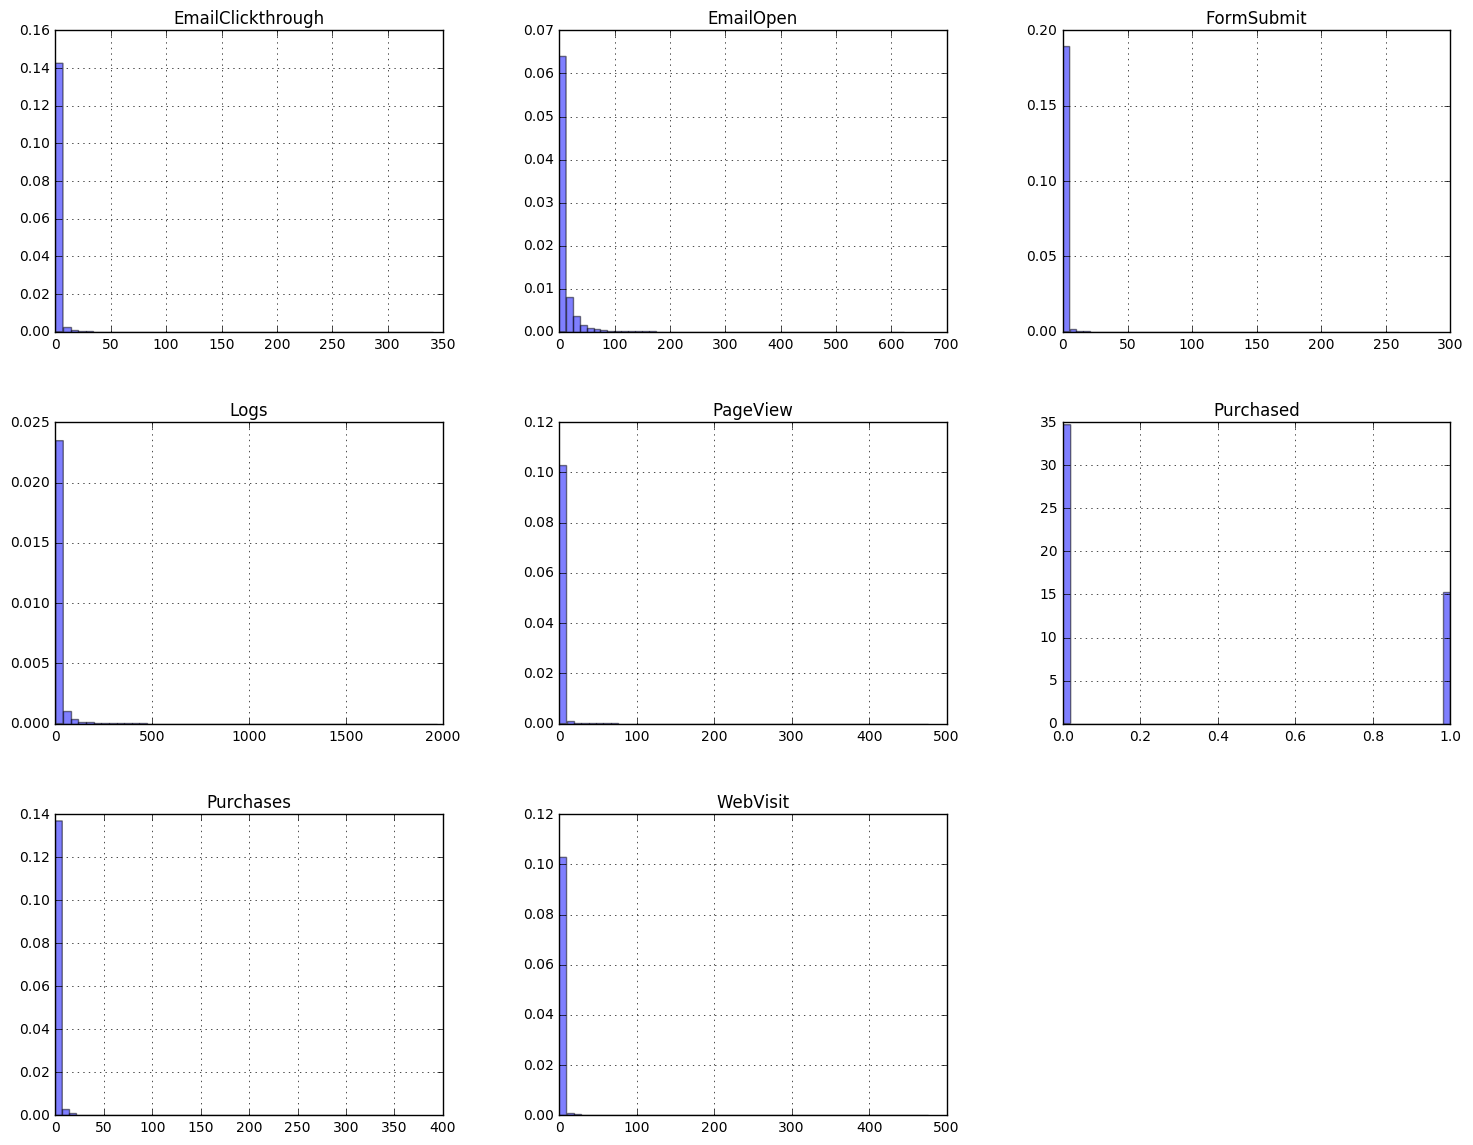

In [47]:
training_data = training_data[list(training_data)[2:]]
training_data.hist(alpha=0.5, bins=50, figsize=(18, 14) , normed = True);

In [48]:
training_data.corr()

,EmailClickthrough,EmailOpen,FormSubmit,PageView,WebVisit,Logs,Purchased,Purchases
EmailClickthrough,1.000000,0.688520,0.769532,0.627488,0.628243,0.810514,0.085819,0.396072
EmailOpen,0.688520,1.000000,0.607651,0.526258,0.526985,0.887660,0.098269,0.422265
FormSubmit,0.769532,0.607651,1.000000,0.585521,0.588880,0.749905,0.075280,0.447306
PageView,0.627488,0.526258,0.585521,1.000000,0.999852,0.836133,0.096809,0.331459
WebVisit,0.628243,0.526985,0.588880,0.999852,1.000000,0.836823,0.096672,0.331841
Logs,0.810514,0.887660,0.749905,0.836133,0.836823,1.000000,0.153418,0.540705
Purchased,0.085819,0.098269,0.075280,0.096809,0.096672,0.153418,1.000000,0.344465
Purchases,0.396072,0.422265,0.447306,0.331459,0.331841,0.540705,0.344465,1.000000


In [49]:
# customer support was not used in the prediction because future customers
# have not yet used this service, therefore cannot be a feature for prediction

col = ['EmailClickthrough','EmailOpen','FormSubmit','PageView','WebVisit','Logs']
label = 'Purchased'

# Finding the number of purchased customers

In [129]:
len(training_data[training_data['Purchased']==1]) / len(training_data)

0.30572445165067785

In [134]:
purchased = training_data[training_data['Purchased']==1]

# Fitting the model

In [250]:
X = training_data[col]
y = training_data[label]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.5, random_state=42)
GB = GradientBoostingClassifier()

In [251]:
GB.fit(X_train,y_train)
GB.score(X_test,y_test)

0.9159585647800631

# Feature Importance

In [252]:
features = [[i,round(j,5)] for i,j in zip(col,GB.feature_importances_)]
features_sorted = sorted(features, key= lambda x: x[1] ,reverse=True)
features_sorted

[['Logs', 0.40337],
 ['EmailOpen', 0.32932],
 ['FormSubmit', 0.0939],
 ['EmailClickthrough', 0.08679],
 ['WebVisit', 0.05673],
 ['PageView', 0.02989]]

In [253]:
feature_names = [ i[0] for i in features_sorted]
feature_importance = [ i[1] for i in features_sorted]

In [254]:
feature_importance

[0.40337, 0.32932, 0.0939, 0.08679, 0.05673, 0.02989]

In [255]:
feature_names.reverse()

# The most important features are how many times someone logged in and emails opened which led to a purchase

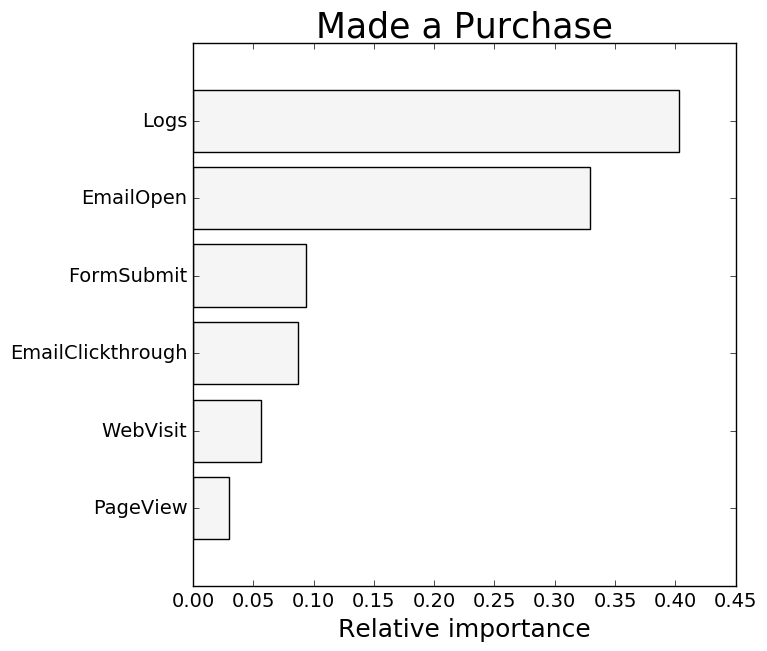

In [256]:
#combined features
plt.figure(figsize=(7,7))
plt.barh(range(len(feature_importance)),sorted(feature_importance),align='center', color = 'whitesmoke')
plt.yticks(range(len(feature_names)),feature_names)
plt.xticks(fontsize=14)
plt.xlabel('Relative importance', fontsize=18)
plt.title('Made a Purchase', size = 25)
plt.yticks(fontsize=14)
plt.show()

ROC AUC: 0.99
Accuracy: 0.91595856478
Precision: 0.941489361702
Recall: 0.775635407537
F1-score: 0.850552618933


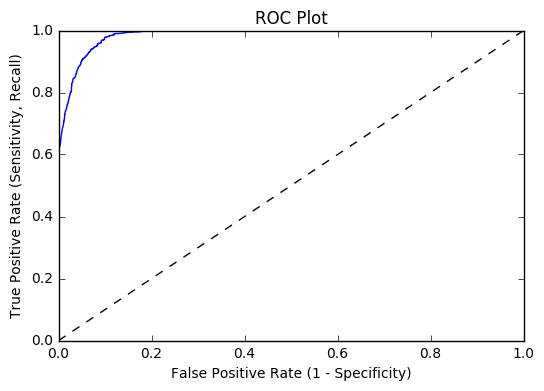

In [257]:
probabilities = GB.predict_proba(X_test)[:, 1]
# predicting 1's

fpr,tpr,threshold = roc_curve(y_test,probabilities)

# activating roc_curve 

roc_auc = auc(fpr, tpr)
print "ROC AUC: %0.2f" % roc_auc
print_metrics(y_test, GB.predict(X_test))


plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Plot")
plt.show()

Confusion matrix, without normalization
[[22541   495]
 [ 2304  7965]]


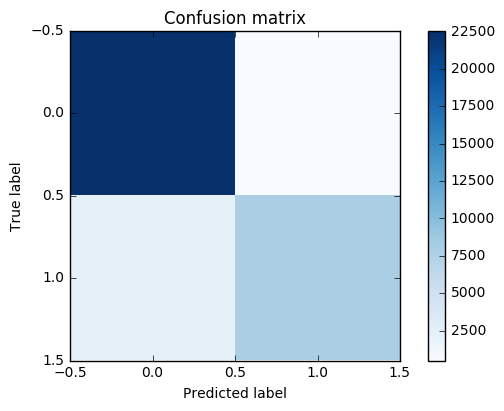

In [258]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Compute confusion matrix
cm = confusion_matrix(y_test, GB.predict(X_test))
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

plt.show()

# Created a Regression to estimate how many someone will purchase

In [259]:
X = np.asarray([training_data['EmailClickthrough'],
                training_data['EmailOpen'],
                training_data['FormSubmit'],
                training_data['PageView'],
                training_data['WebVisit'],
                training_data['Logs']]).T
y = np.asarray(training_data['Purchases'])  # took days out

model = GradientBoostingRegressor()

X_train , X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

model.fit(X_train,y_train)

predict = model.predict(X_test)

In [260]:
model.feature_importances_

array([ 0.05,  0.27,  0.05,  0.13,  0.18,  0.32])

In [261]:
features = [[i,round(j,5)] for i,j in zip(col,model.feature_importances_)]
features_sorted = sorted(features, key= lambda x: x[1] ,reverse=True)
features_sorted

[['Logs', 0.32241],
 ['EmailOpen', 0.26711],
 ['WebVisit', 0.17837],
 ['PageView', 0.13375],
 ['EmailClickthrough', 0.05296],
 ['FormSubmit', 0.04541]]

In [262]:
feature_names = [ i[0] for i in features_sorted]
feature_importance = [ i[1] for i in features_sorted]

In [263]:
feature_names.reverse()

# The same feature importance for a purchase also was the same for how many purchased as well.  I estimated on average that a person will purchase 3 items over it’s lifetime versus 4 for the training set.  



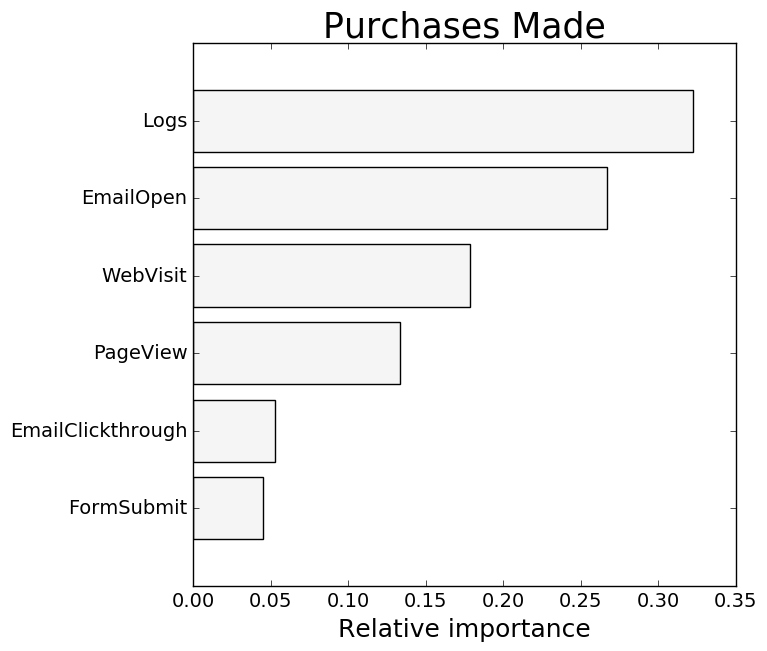

In [264]:
plt.figure(figsize=(7,7))
plt.barh(range(len(feature_importance)),sorted(feature_importance),align='center', color = 'whitesmoke')
plt.yticks(range(len(feature_names)),feature_names)
plt.xticks(fontsize=14)
plt.xlabel('Relative importance', fontsize=18)
plt.title('Purchases Made', size = 25)
plt.yticks(fontsize=14)
plt.show()


# Based on the scatter plot, the Regression model was moderately successful in predictions.  

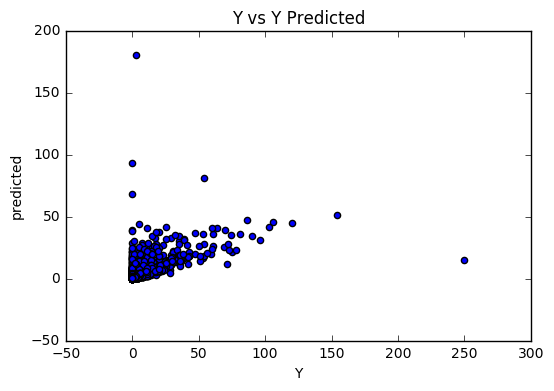

In [265]:
plt.scatter(y_test,predict);
plt.title('Y vs Y Predicted')
plt.xlabel('Y')
plt.ylabel('predicted')

In [266]:
testing_data = pd.read_csv('testing_set.csv')
testing_data.head()

,ID,FormSubmit,EmailOpen,EmailClickthrough,PageView,WebVisit,Logs,PredictPurchase,EstimatedPurchases
0,e6487f04a44444f,0,0,0,1,1,2,0.685508,1
1,c88480d19b2a617,0,3,0,0,0,3,0.027066,0
2,8cc15e801900cc4,0,2,0,0,0,2,0.017591,0
3,1a07e9bd3298a93,2,14,2,2,2,22,0.251876,1
4,3a9956a86a11033,0,6,0,0,0,6,0.046197,0


In [267]:
n = testing_data[['EmailClickthrough','EmailOpen','FormSubmit','PageView','WebVisit','Logs']].values

In [268]:
predictions = GB.predict_proba(n)

In [269]:
n_ = testing_data[['EmailClickthrough','EmailOpen','FormSubmit','PageView','WebVisit','Logs']].values

In [270]:
estimated_purchase = model.predict(n_)

# At max, someone may purchase up to 18 items

In [271]:
max(estimated_purchase)

18.274283587732342

In [272]:
predictions = GB.predict_proba(n)[:,1]

In [273]:
predicted = GB.predict(n)

In [274]:
predicted

array([1, 0, 0, ..., 0, 0, 0])

# Model predicts that only 2% of the people in the test set will purchase

In [275]:
sum(predicted) / len(testing_data)

0.026616971613583316

In [276]:
testing_data["PredictPurchase"] = predictions

In [277]:
testing_data['EstimatedPurchases'] = [0 if i<=1 else np.round(i) for i in estimated_purchase]

# Will this person purchase? 

In [278]:
testing_data.sort_values(by=['PredictPurchase'], ascending=[False]).head()

,ID,FormSubmit,EmailOpen,EmailClickthrough,PageView,WebVisit,Logs,PredictPurchase,EstimatedPurchases
74951,8070b641c86681d,0,0,0,23,23,46,0.982402,6.0
39237,323c7284034098b,0,0,0,44,44,88,0.980943,6.0
130602,612df76dc1ac3ed,0,0,0,11,11,22,0.980911,5.0
55253,490267b17a2462b,0,0,0,11,11,22,0.980911,5.0
116710,bb11509dcc926c9,0,0,0,11,11,22,0.980911,5.0


# How many will the person purchase? 

In [279]:
testing_data.sort_values(by=['EstimatedPurchases'], ascending=[False]).head()

,ID,FormSubmit,EmailOpen,EmailClickthrough,PageView,WebVisit,Logs,PredictPurchase,EstimatedPurchases
54825,3ff1feb5b674e3a,59,63,19,54,69,264,0.754919,18.0
74774,1137a7de4a56a09,52,60,19,29,55,215,0.809713,17.0
128111,7c21520dc24c16f,58,65,24,49,63,259,0.754919,17.0
90858,fb2568cc6e4f93a,20,70,31,58,58,237,0.823669,17.0
7701,61d714a24ee246f,19,74,26,22,22,163,0.801019,16.0


In [280]:
purchase_test =testing_data[testing_data['PredictPurchase']>.5]

In [281]:
np.mean(purchase_test) # estimated average purchase per user lifetime on test set.

FormSubmit             2.194342
EmailOpen             14.949929
EmailClickthrough      3.596888
PageView              10.822631
WebVisit              10.874399
Logs                  42.438190
PredictPurchase        0.672159
EstimatedPurchases     3.278925
dtype: float64

In [282]:
np.mean(training_data[training_data['Purchased']==1])  # average purchase per user lifetime.

CustomerSupport       1.000000
EmailClickthrough     1.524357
EmailOpen            13.884649
FormSubmit            0.898841
PageView              2.761982
WebVisit              2.763308
Logs                 26.972697
Purchased             1.000000
Purchases             4.139560
dtype: float64

FUTURE WORK:
- Feature engineering to reduce the model size for features that are not relevant.
- Run more Diagnostics for Regression model to produce more accurate estimates of purchasers.
- Further research why the training set lists 30% of people made a purchase, but only predicted -2% will purchase from the actual test set.  It did so well on the train/test split.
- Collect Customer Support data and more features,  to see if it makes an impact.
- Automatic data aggregation in a SQL database, where as new logs come in, it will either create a new row for a new user, or update a current row.
